# Try Autoencoder for this data set

In [2]:
import torch as th
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from utils import correlation_map_with_CCF
from IPython.display import clear_output

In [3]:
#load_data
tmp = np.load('../data/imputed_data_kNN_neighbor_6_weights_distance.npz')
data = tmp['imputed']
selected = tmp['selected']
original_shape = data.shape

In [65]:
#preprocess remove the values at non-selected region
#data[:, np.logical_not(selected[0])] = 0

In [66]:
#define_model autoencoder

class Encoder(th.nn.Module):
    def __init__(self, input_dim, num_neurons1, num_neurons2):
        super(Encoder, self).__init__()
        self.pipe = th.nn.Sequential(
            th.nn.Linear(input_dim, num_neurons1, bias=False),
            th.nn.LeakyReLU(negative_slope=0.0, inplace=True),
            th.nn.Linear(num_neurons1, num_neurons2, bias=False),
            #th.nn.LeakyReLU(negative_slope=0.01, inplace=True),
        )
    def forward(self, x):
        return self.pipe(x)#.view(x.size()[0],-1))

class Decoder(th.nn.Module):
    def __init__(self, num_neurons2, output_dim, init_patterns = None):
        super(Decoder, self).__init__()
        if init_patterns is None:
            init_patterns = np.random.uniform(0, 0.0001, (num_neurons2, output_dim)).astype(np.float32)
        self.patterns = th.nn.Parameter(th.tensor(init_patterns), requires_grad = True)
        
    def forward(self, x):
        return th.mm(th.abs(x), th.abs(self.patterns))#.view(-1, 67, 41, 58)

In [67]:
#define_function
BATCH_SIZE = 128
def iterate_batches(X, batch_size=BATCH_SIZE):
    X = X.astype(np.float32)
    i = 0    
    iter = 0
    while True:
        if i + BATCH_SIZE > X.shape[0]:
            X = np.random.permutation(X)
            i = 0
        yield iter, th.tensor(X[i:(i+BATCH_SIZE),:])
        i = i + BATCH_SIZE
        iter += 1

In [184]:
#prepare_training
#hyperparameteres

LEARNING_RATE = 1e-4
NUM_NEURONS_LAYER1 = 500
NUM_NEURONS_LAYER2 = 18

#init_model
#X = np.reshape(data, (data.shape[0], data.shape[1] * data.shape[2] * data.shape[3]))
X = data[:,selected[0]]
#input_dim = data.shape[1] * data.shape[2] * data.shape[3]
input_dim = X.shape[1]
output_dim = input_dim
encoder = Encoder(input_dim, 
                  num_neurons1=NUM_NEURONS_LAYER1,
                  num_neurons2=NUM_NEURONS_LAYER2)
decoder = Decoder(num_neurons2=NUM_NEURONS_LAYER2,
                  output_dim = output_dim)
optim_encoder = th.optim.Adam(params=encoder.parameters(), lr=LEARNING_RATE, betas=(.5, .999))
l2loss = th.nn.MSELoss(reduction='mean')
optim_decoder = th.optim.Adam(params=decoder.parameters(), lr=LEARNING_RATE, betas=(.5, .999), weight_decay = 0) # weight decay is L2 penalty
obj_during_training = []

In [186]:
decoder.patterns.norm(dim=1)

tensor([0.0201, 0.0201, 0.0202, 0.0201, 0.0201, 0.0201, 0.0201, 0.0201, 0.0201,
        0.0201, 0.0201, 0.0201, 0.0201, 0.0201, 0.0201, 0.0201, 0.0201, 0.0202],
       grad_fn=<NormBackward1>)

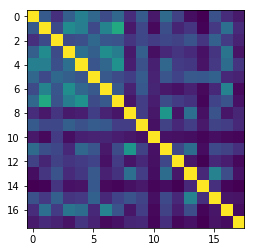

In [242]:
normed_patterns = decoder.patterns.abs() / decoder.patterns.norm(dim=1)[:, None]
plt.imshow(th.mm(normed_patterns, normed_patterns.transpose(0,1)).abs().data.numpy())

In [252]:
#fit_model train autoencoder
for iter, batch in iterate_batches(X):
    encoder.zero_grad()  # zero out the gradient
    decoder.zero_grad()
    codes = encoder(batch)
    output = decoder(codes)
    normed_patterns = decoder.patterns.abs() / decoder.patterns.norm(dim=1)[:, None]
    obj = l2loss(output, batch) / batch.pow(2).mean((0,1)) + 1e-1 * th.mm(normed_patterns, normed_patterns.transpose(0,1)).abs().mean()#+ output.abs().mean() * 1e-4 
    obj_during_training.append((obj).tolist())
    obj.backward()
    optim_encoder.step()
    optim_decoder.step()
    if iter % 10 == 0:
        clear_output()
    print('now at iteration {}'.format(iter))
    if iter > 40000:
        break

now at iteration 370
now at iteration 371
now at iteration 372
now at iteration 373
now at iteration 374
now at iteration 375


KeyboardInterrupt: 

In [253]:
#preprocess extract patterns
PPs = np.zeros((18, data.shape[1], data.shape[2], data.shape[3]))
PPs[:,selected[0]] = abs(decoder.patterns.data.numpy())
#PPs = np.reshape(abs(decoder.patterns.data.numpy()),(18, data.shape[1], data.shape[2], data.shape[3]))

#PPs = np.reshape(PPs, (18, *original_shape[1:]))

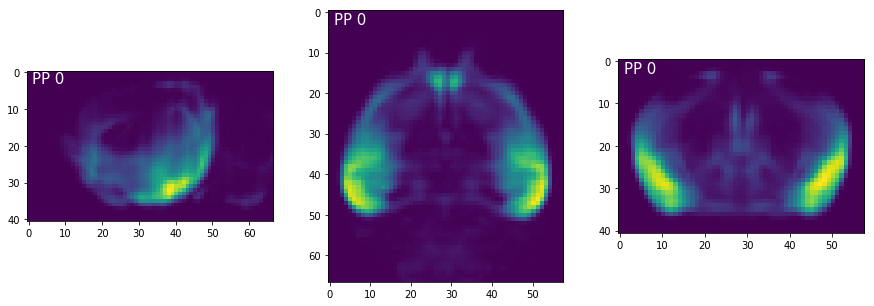

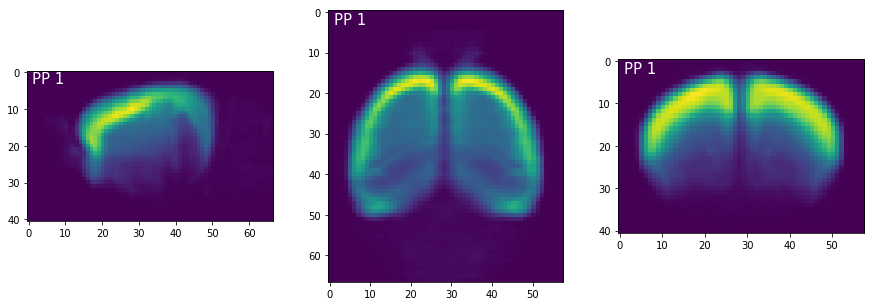

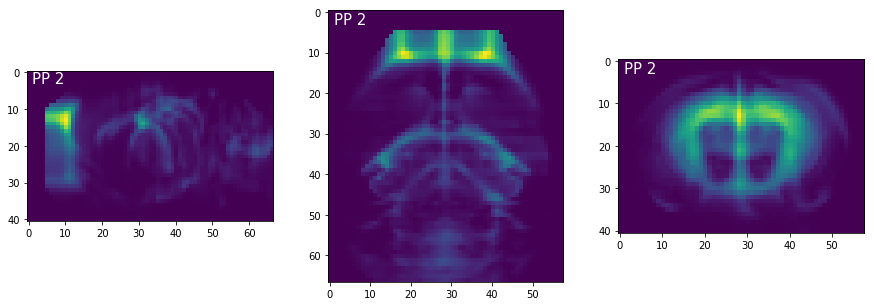

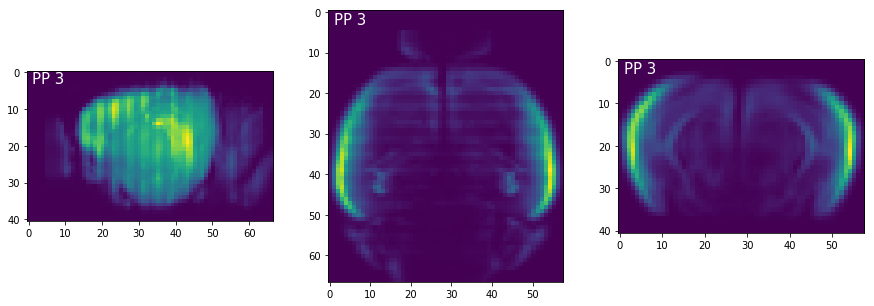

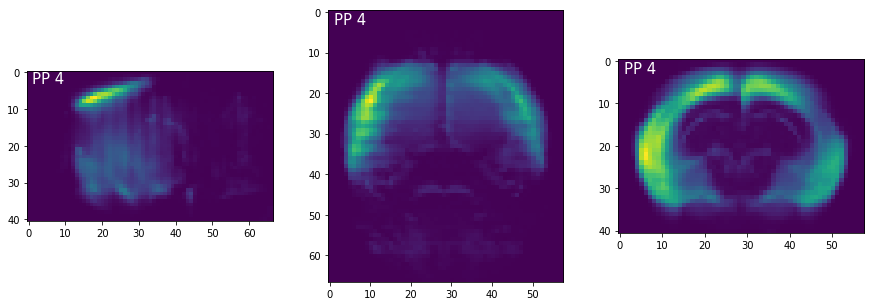

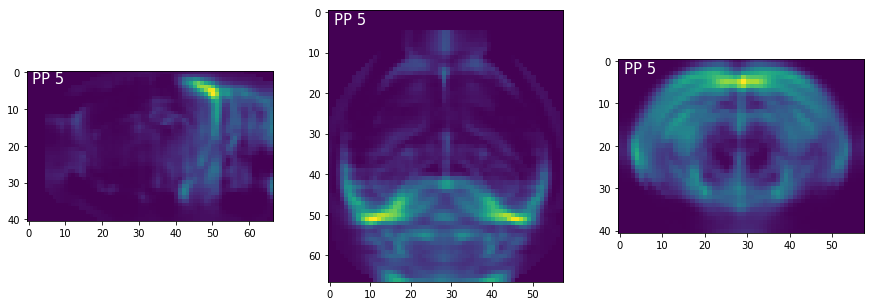

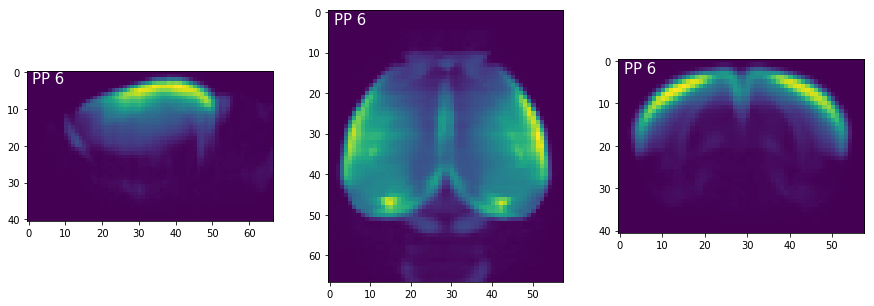

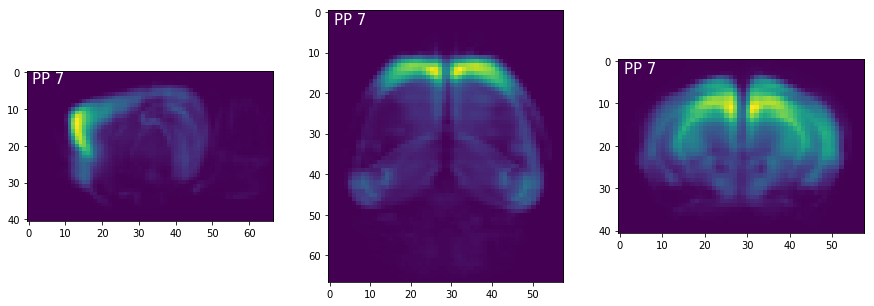

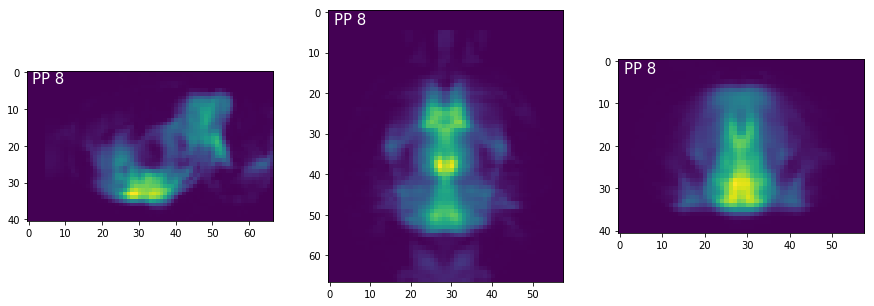

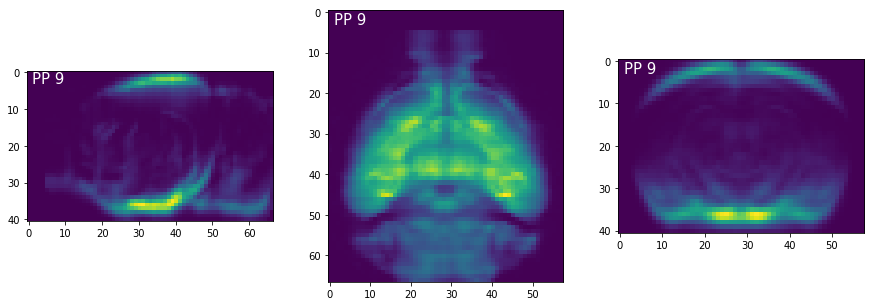

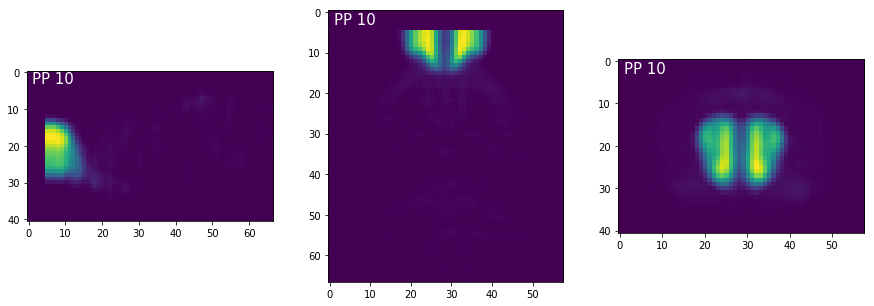

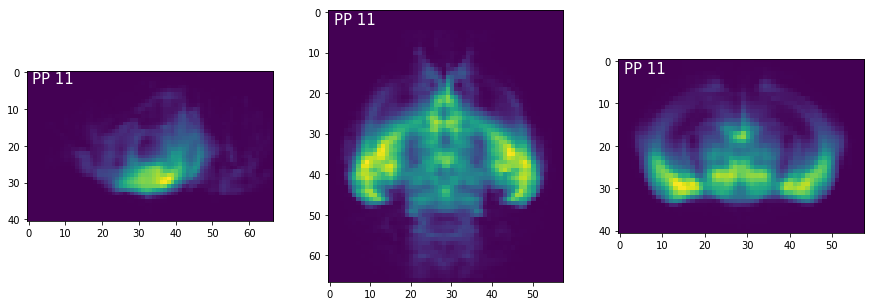

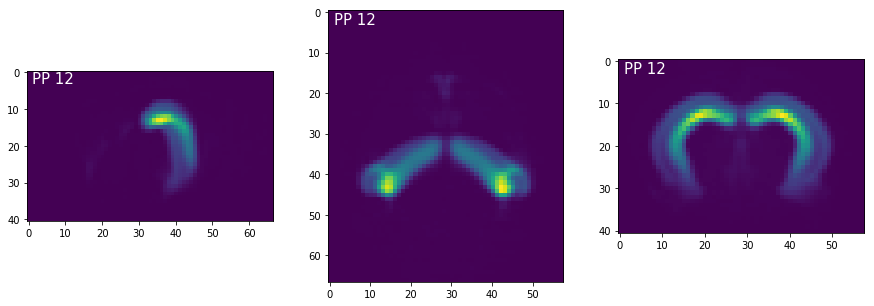

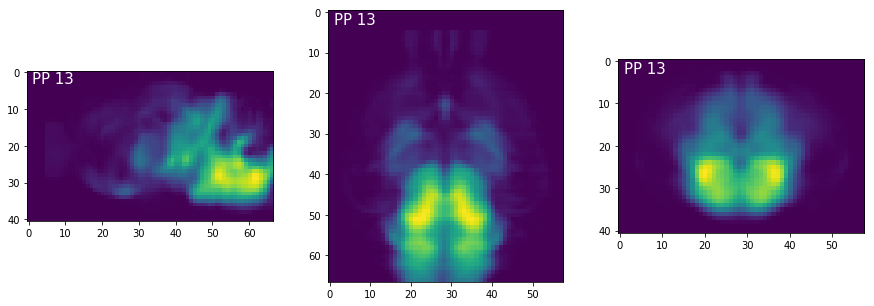

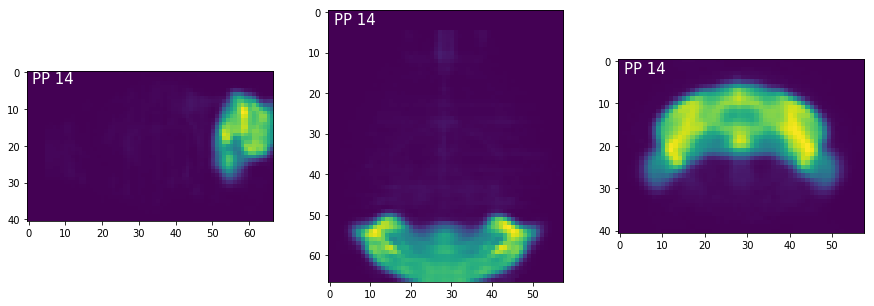

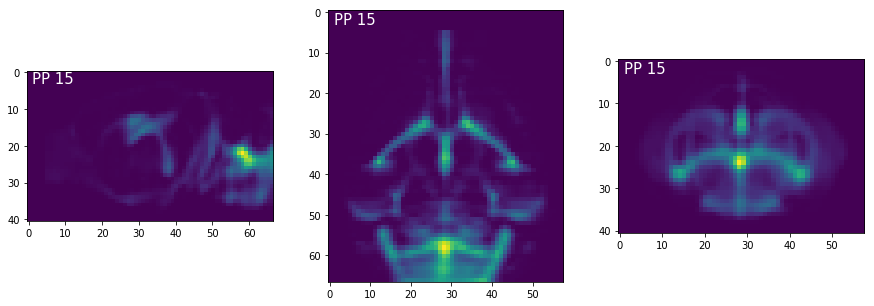

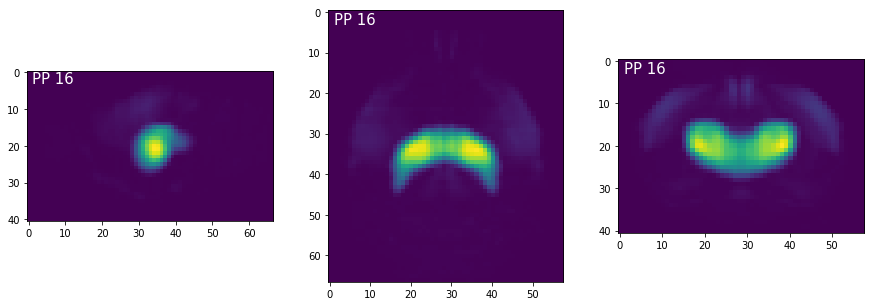

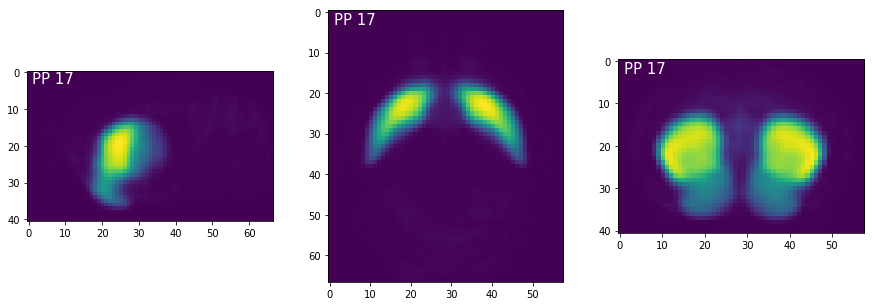

In [254]:
#visualize patterns

for i in range(18):
    _, (a, b, c) = plt.subplots(1, 3, figsize=(15, 5))
    a.imshow(np.mean(PPs[i, :, :, :], 2).T)
    b.imshow(np.mean(PPs[i, :, :, :], 1))
    c.imshow(np.mean(PPs[i, :, :, :], 0))
    a.text(1, 3, 'PP {}'.format(i), color='w', fontsize=15)
    b.text(1, 3, 'PP {}'.format(i), color='w', fontsize=15)
    c.text(1, 3, 'PP {}'.format(i), color='w', fontsize=15)

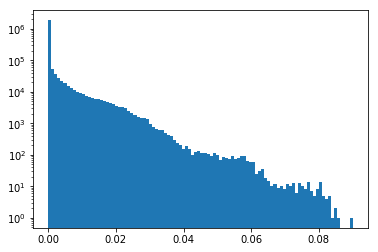

In [255]:
#visualize the PP loadings
plt.hist(decoder.patterns.abs().data.numpy().flatten(),100)
plt.yscale('log')
plt.show()


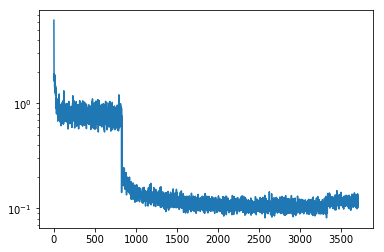

In [256]:
#visualize the objective_during_training
plt.plot(obj_during_training[0:])
plt.yscale('log')

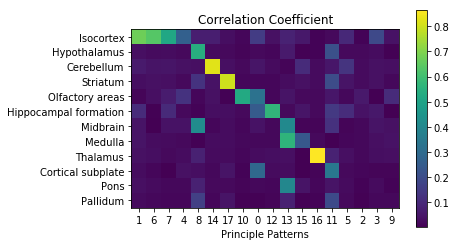

In [6]:
#visualize the correlation with the reference map
corr_mat = correlation_map_with_CCF(PPs, np.array(original_shape), order_type=2,area_order=[1,9,3,11,4,8,0,2,10,5,6,7], put_last_k=4)

In [8]:
#load reference atlas
areas_atlas = np.load('mouse_coarse_structure_atlas.npy')
mouse_coarse_df = pd.read_pickle('mouse_coarse_df')

In [9]:
# preprocess compute the support
support = np.sum(areas_atlas, 0) > 0

In [11]:
new_PPs = PPs[:,:-1,:-1,:-1] * support

In [12]:
def correlation_map_with_CCF(PPs, original_shape, plot=True, order_type = 1, area_order=None, put_last_k = 0, save_fig = False, save_index = None):
    ''' Compare PPs with the standard ABA CCF.
    '''
    # transform PPs to 4d tensor
    PPs_3d = np.zeros([PPs.shape[0]] + original_shape[1:].tolist())
    num_pps = PPs.shape[0]
    for i in range(PPs.shape[0]):
        p2 = np.reshape(PPs[i,:], original_shape[1:])
        PPs_3d[i,:,:,:] = p2
    # load ABA CCF coarse
    areas_atlas = np.load('mouse_coarse_structure_atlas.npy')
    mouse_coarse_df = pd.read_pickle('mouse_coarse_df')
    if area_order != None:
        cor_mat = np.corrcoef(np.vstack([areas_atlas.reshape(12, -1)[np.array(area_order)], PPs_3d.reshape(num_pps,-1)]))[:areas_atlas.shape[0], areas_atlas.shape[0]:]
    else:
        cor_mat = np.corrcoef(np.vstack([areas_atlas.reshape(12, -1), PPs_3d.reshape(num_pps,-1)]))[:areas_atlas.shape[0], areas_atlas.shape[0]:]
    
    if order_type == 1:
        rows, cols = linear_sum_assignment(-np.abs(cor_mat))
        factor_order = list(cols) + [x for x in range(num_pps) if x not in cols]
    elif order_type == 2:
        cols = np.argmax(np.abs(cor_mat), 0)
        if put_last_k > 0:
            # put the poorly fitted patterns at the last.
            best_fits = [abs(cor_mat[y, x]) for x, y in enumerate(cols)]
            orders = np.argsort(best_fits)
            for i in range(put_last_k):
                cols[orders[i]] = max(cols) 
        factor_order = np.argsort([ 10 * x - abs(cor_mat[x, i]) for i, x in enumerate(cols.tolist())]) # first sort by x, then sort by the value
                
            
    if plot:
        fig = plt.gcf()
        plt.imshow(np.abs(cor_mat[:,factor_order]).tolist())
        if area_order is None:
            plt.yticks(np.arange(12),(mouse_coarse_df.iloc[:]['name'].tolist()))
        else:
            plt.yticks(np.arange(12),(mouse_coarse_df.iloc[area_order]['name'].tolist()))
        plt.ylim([-0.5, 11.5])
        plt.gca().invert_yaxis()
        plt.xticks(range(num_pps), factor_order)
        plt.title('Correlation Coefficient')
        plt.xlabel('Principle Patterns')
        plt.colorbar()
        plt.show()
        if save_fig:
            fig.savefig('plot_{}.png'.format(save_index))
    return np.abs(cor_mat[:,factor_order])

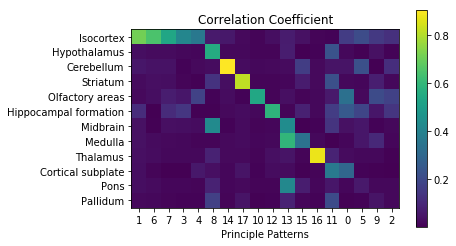

In [13]:
#visualize the correlation with the reference map
corr_mat = correlation_map_with_CCF(new_PPs.reshape((18,-1)), np.array(new_PPs.shape), order_type=2,area_order=[1,9,3,11,4,8,0,2,10,5,6,7], put_last_k=4)

In [15]:
corr_mat[2]

array([0.05590747, 0.04418865, 0.04298229, 0.00962209, 0.02337197,
       0.02864485, 0.90514754, 0.03067609, 0.01989138, 0.02285897,
       0.02482334, 0.16388871, 0.02474083, 0.04697898, 0.04759252,
       0.2212788 , 0.0033422 , 0.11872994])

In [258]:
#store_model
np.savez("../data/04_18_autoencoder_result_10pm_Feb_27_with_sparsity.npz", PPs = PPs)

In [4]:
tmp = np.load("../data/04_18_autoencoder_result_10pm_Feb_27_with_sparsity.npz")

In [5]:
PPs = tmp['PPs']